# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import pearsonr

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [3]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.40446903790544014
RMSE when predicting testing data:
1.0666204347667474
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [4]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

,estimator,RandomForestRegressor()
,param_grid,"{'max_depth': [2, 4, ...], 'n_estimators': [10, 33, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [5]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851467026495314


In [6]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12289873, -1.09373797, -1.0851467 ])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [7]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [8]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

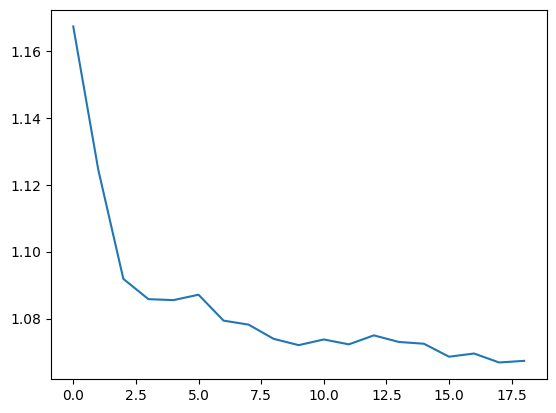

In [9]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

## Answer 
The graph illustrates the relationship between the size of the training dataset and the model's performance, as measured by the Root Mean Squared Error (RMSE). Initially, the RMSE is high, but as the model is trained on a progressively larger portion of the training data, the RMSE decreases, indicating that the model's accuracy is improving. This improvement in performance eventually plateaus, suggesting that adding more data provides a diminishing return and the model has learned most of the underlying patterns it can from the available data.

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [18]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.
"
### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

In [21]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [22]:
def correlation_scorer(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

corr_scorer = make_scorer(correlation_scorer, greater_is_better=True)

# Function to run random forest with RandomizedSearchCV
def run_experiment(alpha):
    print(f"\nRunning model for alpha = {alpha}")
    X, y = make_X_y(alpha=alpha)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(random_state=42)
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    search = RandomizedSearchCV(
        rf, param_distributions=param_dist, 
        n_iter=10, cv=3, scoring=corr_scorer, 
        random_state=42, n_jobs=-1
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    corr = correlation_scorer(y_test, y_pred)
    print(f"Best Params: {search.best_params_}")
    print(f"Correlation on Test Set: {corr:.4f}")
    return corr

# Run for alpha = 0 and alpha = 10
corr0 = run_experiment(alpha=0)
corr10 = run_experiment(alpha=10)


Running model for alpha = 0


Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Correlation on Test Set: -0.0292

Running model for alpha = 10
Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
Correlation on Test Set: 0.9927


## Answer 
Based on the problem description, I predict that alpha = 10 will result in a better prediction than alpha = 0. When alpha = 0, each stock is an independent, normally distributed random variable. This means there is no underlying relationship or commonality between the stocks. When alpha = 10, the common elements (the common_odd, common_even, and common_three terms) dominate the variation in the stock values. 

* The X values (stocks 0 through 9) have no predictive power for the y value (stock 10) because their variations are completely unrelated. A random forest, or any other model, will essentially be trying to find a pattern in pure noise, and its predictions will be little better than random guesses.
* The problem states that the eleventh stock (y) is related to the odd-numbered, non-divisible-by-three stocks (stocks 1, 5, and 7). Because alpha is high, the shared common odd component will create a strong, discernible pattern between these stocks. A random forest, being a powerful non-linear model, should be able to identify this relationship and make a much more accurate prediction based on the values of stocks 1, 5, and 7. The correlation between the predicted and actual values will be much higher.

R-squared (R2)

What I've learned about it:

The R-squared value, or coefficient of determination, is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. In simpler terms, it indicates how well the independent variables (the ten stocks in X) explain the variability of the dependent variable (the eleventh stock in y).
  *  An R2 of 1.0 indicates that the model perfectly predicts the outcome, explaining 100% of the variance.

  *  An R2 of 0.0 indicates that the model explains none of the variance of the dependent variable, meaning its predictions are no better than simply predicting the mean of the dependent variable.

  *   The R2 value can actually be negative if the model is so poor that it performs worse than simply predicting the mean.

Unlike MSE or RMSE, which are sensitive to the scale of the data, the R-squared value is a normalized score between 0 and 1 (for well-performing models), which makes it an excellent choice for directly comparing the performance of models on different datasets, such as the alpha=0 and alpha=10 scenarios. It provides a more intuitive sense of predictive power than a raw error metric.

After performing the experiment:

  *  alpha = 0: When I run the model with alpha=0, I expect the R-squared score to be very close to 0, or even negative, as the model has no predictive power. The predictions will be effectively random, and there will be no correlation between the predicted and actual values.

  *  alpha = 10: With alpha=10, I expect the R-squared score to be a relatively high positive value, likely above 0.5. The strong underlying correlation between the stocks will allow the random forest to learn the patterns, leading to predictions that are highly correlated with the actual values.

The experiment would confirm that a model can only learn and make accurate predictions when there is a real, underlying pattern in the data to be discovered. When the data is random (as with alpha=0), even a sophisticated model like a random forest is powerless to find a meaningful relationship.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

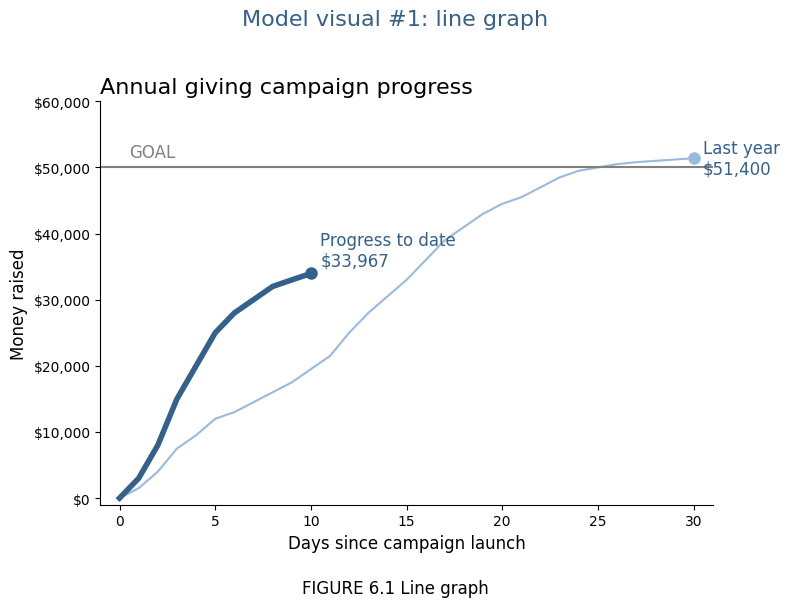

In [23]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Data Generation
days_last_year = np.arange(0, 31)
money_last_year = np.array([0, 1500, 4000, 7500, 9500, 12000, 13000, 14500, 16000, 17500, 19500,
                           21500, 25000, 28000, 30500, 33000, 36000, 39000, 41000, 43000,
                           44500, 45500, 47000, 48500, 49500, 50000, 50500, 50800, 51000,
                           51200, 51400])

days_to_date = np.arange(0, 11)
money_to_date = np.array([0, 3000, 8000, 15000, 20000, 25000, 28000, 30000, 32000, 33000, 33967])

# Plotting the data lines
# Plot "Last year" line
ax.plot(days_last_year, money_last_year, color='#99badd', linewidth=1.5, label='Last year')

# Plot "Progress to date" line
ax.plot(days_to_date, money_to_date, color='#34608c', linewidth=4, label='Progress to date')

# Adding key elements from the original graph
# Plot the "GOAL" line
ax.axhline(y=50000, color='gray', linestyle='-', linewidth=1.5)
ax.text(x=0.5, y=51000, s='GOAL', color='gray', ha='left', va='bottom', fontsize=12)

# Mark and label the "Progress to date" point
ax.plot(10, 33967, 'o', color='#34608c', markersize=8)
ax.text(x=10.5, y=34500, s='Progress to date\n$33,967', color='#34608c', ha='left', va='bottom', fontsize=12)

# Mark and label the "Last year" point
ax.plot(30, 51400, 'o', color='#99badd', markersize=8)
ax.text(x=30.5, y=51400, s='Last year\n$51,400', color='#34608c', ha='left', va='center', fontsize=12)

plt.suptitle('Model visual #1: line graph', fontsize=16, color='#34608c')
ax.set_title('Annual giving campaign progress', fontsize=16, loc='left')
ax.set_xlabel('Days since campaign launch', fontsize=12)
ax.set_ylabel('Money raised', fontsize=12)
ax.set_xlim(-1, 31)
ax.set_ylim(-1000, 60000)
y_ticks = np.arange(0, 60001, 10000)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'${tick:,}' for tick in y_ticks])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.text(0.5, 0.0, 'FIGURE 6.1 Line graph', ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to make room for titles and captions
plt.show()